# Machine Learning Exercise #4 - Neural Networks

이 연습을 위해 우리는 손으로 쓴 숫자 데이터 세트를 다시 다루겠습니다. 이번에는 역전파(backpropagation)와 피드 포워드 신경망을 사용합니다. 우리는 역전파 알고리즘을 통해 신경망 비용 함수와 기울기 계산의 정규화되지 않은 것과 정규화 된 버전을 구현할 것입니다. 랜덤 가중치 초기화와 네트워크를 사용하여 예측을 수행하는 방법도 구현할 것입니다.

데이터는 연습 3에서 사용한 데이터 세트와 동일하므로, 다음과 같이 코드를 다시 사용하여 데이터를 로드합니다.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('ex3data1.mat')
data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

나중에 이들을 필요로 할 것이므로(그리고 자주 사용하기도 합니다), 유용한 변수를 미리 만들어 보겠습니다.

In [28]:
print(type(data))
print(type(data['X']))
print(type(data['y']))
X = data['X']
y = data['y']
X.shape, y.shape

<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


((5000, 400), (5000, 1))

### 자료 시각화

다음의 코드는 데이터를 2 차원 플롯으로 표시합니다. 이것은 이전 연습에서 사용한 것과 동일한 데이터 세트입니다. 5000 개의 학습 예제가 있으며 각 연습 예제는 20x20 픽셀 회색 음영 이미지입니다. 각 픽셀은 해당 위치에서 그레이 스케일 강도를 나타내는 부동 소수점 숫자로 표시됩니다. 20 x 20 픽셀 격자는 400 차원 벡터로 주어집니다. 이 훈련 예제는 우리의 데이터 행렬 $X$에서 하나의 행이 됩니다.이 행렬은 손으로 쓴 자릿수 이미지에 대한 모든 행이 훈련 예제 인 5000 x 400 행렬 $X$를 제공합니다.
$$ X = \begin{bmatrix}
         (x^{(1)})^T\\
        (x^{(2)})^T  \\
        \vdots\\
       (x^{(m)})^T \\
         \end{bmatrix}
$$

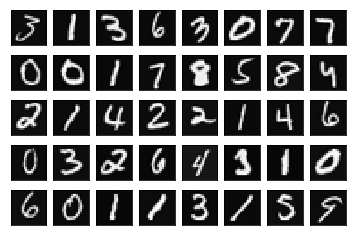

In [29]:
select = np.random.randint(0, 5000, size=40)

fig, axs = plt.subplots(5,8,subplot_kw={'xticks': [], 'yticks': []})

for i in range(5):
    for j in range(8):
        one = np.matrix(X)[select[i*8 + j],:].reshape(20,20)
        axs[i][j].imshow(one.T, cmap='gray')
    
plt.show()

훈련 세트의 두 번째 파트는 트레이닝 세트의 레이블을 포함하는 5000차원 벡터입니다. 인덱스가 1부터 시작하는 Octave / Matlab 인덱싱과 더 잘 호환되도록 숫자 0에 숫자 10을 매핑했습니다. 따라서 숫자 "0"은 "10"으로 표시되고 숫자 "1"~"9"는 자연 순서대로 "1"~"9"로 표시됩니다.

### 모델 표현

우리의 신경망은 아래의 그림 2에 나와 있습니다. 입력 층, 은닉 층 및 출력 층의 3개 층이 있습니다. 입력 값은 숫자 이미지의 픽셀 값입니다. 이미지의 크기가 20 × 20 이므로 400개의 입력 층 노드를 제공합니다 (항상 +1을 출력하는 추가 바이어스 노드 제외). 이전과 마찬가지로, 학습 데이터는 변수 $X$와 $y$에 로드됩니다.  

<img src="./fig2.png" width=400>

### 전방전파 및 비용 함수

이제 신경망에 대한 비용 함수와 그래디언트를 구현할 것입니다. 먼저 다음의 코드를 완성하여 비용을 반환하십시오.

신경망에 대한 비용 함수(정규화되지 않은)는 다음과 같습니다.

$$ J(\theta) = {1\over m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)} \log(h_\theta(x^{(i)})_k) - (1 - y_k^{(i)}) \log(1-h_\theta(x^{(i)})_k)] $$

여기서 $h_\theta (x^{(i)})$는 그림 2와 같이 계산되고, K = 10은 가능한 레이블의 총 수입니다. $h (x^{(i)})_k = a_k^{(3)}$ 는 k 번째 출력 단위의 활성화(출력값)이다. 또한 원래의 레이블 (변수 y에서)은 1, 2, ..., 10 이었지만 신경망을 학습 할 목적으로 레이블을 0 또는 1 만 포함하는 벡터로 다음처럼 표시된 원핫(one-hot) 벡터로 다시 코딩해야 합니다. 

$$ y = \begin{bmatrix}
        1\\ 0\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
        ,
        \begin{bmatrix}
        0\\ 1\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
         , \cdots \text{ or },
         \begin{bmatrix}
        0\\ 0\\ 0\\ \vdots\\ 1\\
         \end{bmatrix}
         $$


우리는 y 레이블을 원핫(one-hot) 인코딩해야 합니다. 원핫인코딩은 클래스 레이블 n (k 클래스들 중에서)을 길이가 K 인 벡터로 바꾸어줍니다. 여기서 인덱스 n은 hot(1)이고, 나머지는 0 입니다. Scikit-learn은 이것을 위해 사용할 수 있는 유틸리티가 내장되어 있습니다.

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [8]:
y[0], y_onehot[0,:]
# y[500], y_onehot[500,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

이 실습을 위해 구축 할 신경망에는 입력 데이터 크기(400 + 바이어스 유닛)의 입력 레이어와, 
25개 단위(바이어스 유닛을 포함하면 26)가 있는 히든 레이어와 함께, 클래스 레이블에 대한 우리의 원핫-인코딩에 해당하는 10 유닛의 출력 레이어가 있습니다. (Figure 2 참조)

우리가 구현해야 할 첫 번째 부분은 주어진 네트워크 매개 변수들에 대한 손실(loss)을 평가하는 비용 함수입니다. 다음은 비용을 계산하는 데 필요한 함수입니다.

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]     # no. of training sample (= 5000) 
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)   # add bias unit for layer 1
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)  # add bias unit for layer 2
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [11]:
def cost0(input_size, hidden_size, num_labels, X, y, theta1, theta2, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    # Problem(1) - score 10 ==============================================
    J = 0
    for i in range(m):
        
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    # ====================================================================
    return J

시그모이드 함수는 이전에도 사용했으므로 새 것이 아닙니다. forward-propagate 함수는 현재 주어진 매개변수로 각 학습 인스턴스에 대한 가설을 계산합니다. 출력 형태는 y에 대한 one-hot 인코딩과 동일해야 합니다. 우리는 이 사실을 빨리 테스트하여 예상대로 작동하고 있음을 확신 할 수 있습니다 (중간 단계도 나중에 유용하므로 반환됩니다).

In [12]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
reg_lambda = 1
epsilon = 0.25

# randomly initialize a parameter array of the size of the full network's parameters
param_size = hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)
# params = np.zeros(param_size)
# Problem 2 (score = 5) ================================================================
params = (np.random.random(size=param_size) * 2 * epsilon ) - epsilon
# ==================================================================================
print(params.shape)
m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

(10285,)


((25, 401), (10, 26))

In [13]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

### 비용 함수는 가설 행렬 h를 계산 한 후 비용 방정식을 적용하여 y와 h 간의 총 오류를 계산합니다. 

코딩이 완료되면 Theta1과 Theta2에 대한 매개 변수 집합을 -0.25~0.25 사이의 무작위 값을 사용하여 cost 함수를 호출합니다. 비용은 약 6.099 입니다.

In [14]:
cost0(input_size, hidden_size, num_labels, X, y_onehot, theta1, theta2, reg_lambda)

7.220436278168392

다음 단계는 비용 함수에 정규화를 추가하는 것입니다. 사실, 정규화 항(regularization term)은 단순히 우리가 이미 계산 한 비용에 더하는 것입니다. 다음은 수정된 비용 함수입니다.

In [15]:
def cost(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

cost(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)

7.241761942281401

다음은 역전파(backpropagation) 알고리즘입니다. 역전파는 훈련자료에 대한 네트워크의 오류를 줄이도록 매개 변수 업데이트를 계산합니다. 우리가 먼저 필요로 하는 것은 우리가 이전에 생성한 시그모이드 함수의 그래디언트를 계산하는 함수입니다.

In [16]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

이제 그라디언트를 계산하기 위해 역전파(backpropagation)를 구현할 준비가 되었습니다. 역전파에 필요한 계산이 비용 함수에서 요구되는 계산을 포함하기 때문에, 실제로 비용 함수를 확장하여 역전파를 수행하고 비용과 그라디언트를 모두 반환하도록 코딩을 합니다. 

In [17]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    # Same as Problem 1 (score 10) =========================================================
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    # ===================================================================================
    # add the cost regularization term
    # Problem 3 (Score 5) =================================================================
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    # =====================================================================================
    # perform backpropagation
    # Problem 4 (Score 15) ===============================================================
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    # ================================================================================
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

(왜 우리가 이 모든 계산을 하는지 이해하는 것 외에) backprop 함수 계산의 가장 어려운 부분은 행렬 차원을 올바르게 얻는 것입니다. 그건 그렇고, A*B 와 np.multiply(A, B)를 헛갈리지 마십시오. 기본적으로 전자는 행렬 곱셈이고 후자는 요소 단위의 곱셈입니다 (A 또는 B가 스칼라 값이라면 상관 없습니다). 

어쨌든 함수가 우리가 기대하는 바를 반환하는지 테스트 해 봅시다.

In [18]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(7.241761942281401, (10285,))

역전파 함수에 또 하나의 수정이 있습니다 - 그라디언트 계산에 정규화 추가.  최종 정규화 버전은 아래와 같습니다.

In [19]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    # Same as Problem 1 (score 10) =========================================================
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    # ===================================================================================
    # Same as Problem 3 (Score 5) =================================================================
    J += (float(reg_lambda) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    # =====================================================================================
    # perform backpropagation
    # Same as Problem 4 (Score 15) ===============================================================
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    # ================================================================================
    # add the gradient regularization term
    # Problem 5 (Score 5) ===============================================================
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * reg_lambda) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * reg_lambda) / m
    # ==================================================================================
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [24]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(7.241761942281401, (10285,))

우리는 마침내 우리의 네트워크를 훈련시키고, 예측을 위해 사용할 준비가 되었습니다. 이것은 다중 클래스 로지스틱 회귀 분석을 사용한 이전의 실습과 거의 비슷합니다. 사용하는 최적화 알고리즘은 scipy.optimize.minimize() 이며 jac=True 로 줄 경우에는, fun=backprop 로 주어지는  함수 backprop() 는 비용함수값과 그레디언트 값을 반환해주는 함수여야한다. 사용 가능한 그라디언트 업데이트 알고리즘( method="  " 로 주어짐)들에는  CG, BFGS, Newton-CG, L-BFGS-B, TNC 등이 있다.  

In [25]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, reg_lambda), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply


     fun: 0.4687689748164321
     jac: array([ 2.15786183e-03, -1.42386182e-05, -8.78047301e-06, ...,
        6.90989474e-05, -2.78214272e-04, -1.04861596e-03])
 message: 'Linear search failed'
    nfev: 216
     nit: 13
  status: 4
 success: False
       x: array([-0.53960529, -0.07119309, -0.04390237, ..., -1.43583019,
        1.59837072,  1.27641506])

우리는 목적 함수가 완전히 수렴하지 않을 것이기 때문에 반복의 수를 제한합니다. 총 비용이 0.5 미만으로 떨어졌다는 것은 알고리즘이 작동 중임을 나타내는 좋은 지표입니다. 찾은 매개 변수를 사용하여 네트워크를 전방향 전파(forward-propagate)를 하여 예측을 얻어내 봅시다.

In [26]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)

마지막으로 정확성을 계산하여 숙련 된 네트워크가 얼마나 잘 작동하는지 확인할 수 있습니다.

In [23]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy =', accuracy * 100, '%')

accuracy = 96.3 %


완료됬습니다. 우리는 역전파(backpropagation) 기능을 갖춘 기본적인 전방향전파(forward feed-forward) 신경망을 성공적으로 구현하여, 손으로 쓴 자릿수의 이미지를 분류하는 데 사용했습니다. 